In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


# MIMIC-CXR Radiologist Annotations

#### microsoft/BiomedVLP-CXR-BERT-specialized

In [4]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "microsoft/BiomedVLP-CXR-BERT-specialized" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: microsoft/BiomedVLP-CXR-BERT-specialized
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=116,1396652957813721259).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 128)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 4637.18it/s]
Computing embeddings for 1165 new texts
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading 

#### microsoft/BiomedVLP-BioViL-T

In [6]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "microsoft/BiomedVLP-BioViL-T" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: microsoft/BiomedVLP-BioViL-T
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=104,2678825193822464594).pkl
len(self.cache["hashes"]) = 4443182
self.cache["embeddings"].shape = (4443182, 128)
100%|██████████████████████████████████████| 1165/1165 [00:05<00:00, 219.42it/s]
Computing embeddings for 1165 new texts
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.83it

#### michiyasunaga/BioLinkBERT-large (cls)

In [7]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "michiyasunaga/BioLinkBERT-large" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: michiyasunaga/BioLinkBERT-large
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=107,40983794350539675).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 1024)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 1843.79it/s]
Computing embeddings for 1165 new texts
100%|███████████████████████████████████████████| 12/12 [00:04<00:00,  2.49it/s]
Saving updated cache to /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=107,40983794350539675).pkl
100%|███████████████████

#### michiyasunaga/BioLinkBERT-large (tok)

In [8]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "michiyasunaga/BioLinkBERT-large" \
--batch_size 100 \
--top_k 500 \
--average_token_embeddings

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: michiyasunaga/BioLinkBERT-large
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: True
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=132,1253761809285128054).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 1024)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 1937.18it/s]
Computing embeddings for 1165 new texts
100%|███████████████████████████████████████████| 12/12 [00:04<00:00,  2.59it/s]
Saving updated cache to /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=132,1253761809285128054).pkl
100%|████████████████

#### microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext (cls)

In [9]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=137,1948119357925567498).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 768)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 2005.30it/s]
Computing embeddings for 1165 new texts
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.pre

#### microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext (cls)

In [10]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" \
--batch_size 100 \
--top_k 500 \
--average_token_embeddings

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: True
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=162,1758876944325999998).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 768)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 2301.47it/s]
Computing embeddings for 1165 new texts
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dens

#### emilyalsentzer/Bio_ClinicalBERT (cls)

In [11]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "emilyalsentzer/Bio_ClinicalBERT" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: emilyalsentzer/Bio_ClinicalBERT
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=107,1542209846559636901).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 768)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 2325.91it/s]
Computing embeddings for 1165 new texts
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight

#### emilyalsentzer/Bio_ClinicalBERT (tok)

In [12]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "emilyalsentzer/Bio_ClinicalBERT" \
--batch_size 100 \
--top_k 500 \
--average_token_embeddings

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: emilyalsentzer/Bio_ClinicalBERT
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: True
len(sentences): 1165
len(labels): 1165
  0%|                                                  | 0/1165 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=132,412155249657523952).pkl
len(self.cache["hashes"]) = 102464
self.cache["embeddings"].shape = (102464, 768)
100%|█████████████████████████████████████| 1165/1165 [00:00<00:00, 2247.38it/s]
Computing embeddings for 1165 new texts
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.pr

#### Oracle

In [14]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "oracle" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: oracle
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
100%|███████████████████████████████████████| 1165/1165 [00:12<00:00, 96.37it/s]
Saving metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200741_mimiccxr_rad_annotations_oracle/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations).pkl


#### CXR Fact Encoder (T)

In [44]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "microsoft/BiomedVLP-CXR-BERT-specialized" \
--model_checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: microsoft/BiomedVLP-CXR-BERT-specialized
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
checkpoint_names = ['checkpoint_40_ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9355.pt']
100%|███████████████████████████████████| 1165/1165 [00:00<00:00, 236960.58it/s]
Computing embeddings for 1165 new texts
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no ma

#### CXR Fact Encoder (T -> T+EC)

In [2]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "mimiccxr_radiologist_annotations" \
--method "microsoft/BiomedVLP-CXR-BERT-specialized" \
--model_checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_225344_MIMIC-CXR(triplets+classif)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: mimiccxr_radiologist_annotations
   method: microsoft/BiomedVLP-CXR-BERT-specialized
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_225344_MIMIC-CXR(triplets+classif)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
len(sentences): 1165
len(labels): 1165
checkpoint_names = ['checkpoint_20_encc+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9437.pt']
100%|███████████████████████████████████| 1165/1165 [00:00<00:00, 405507.40it/s]
Computing embeddings for 1165 new texts
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ens

In [15]:
from importlib import reload
import medvqa

In [23]:
reload(medvqa.utils.files)

<module 'medvqa.utils.files' from '/home/pamessina/medvqa/medvqa/utils/files.py'>

In [26]:
from medvqa.utils.files import list_filepaths_with_prefix_and_timestamps

In [34]:
output = list_filepaths_with_prefix_and_timestamps(
    path_prefix='/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927',
)

In [35]:
filepaths = [x for x, _ in output]

In [36]:
filepaths

['/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200741_mimiccxr_rad_annotations_oracle/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200637_mimiccxr_rad_annotations_emilyalsentzer-Bio_ClinicalBERT/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine,avgtok).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200546_mimiccxr_rad_annotations_emilyalsentzer-Bio_ClinicalBERT/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200454_mimiccxr_rad_annotations_microsoft-BiomedNLP-P

In [40]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

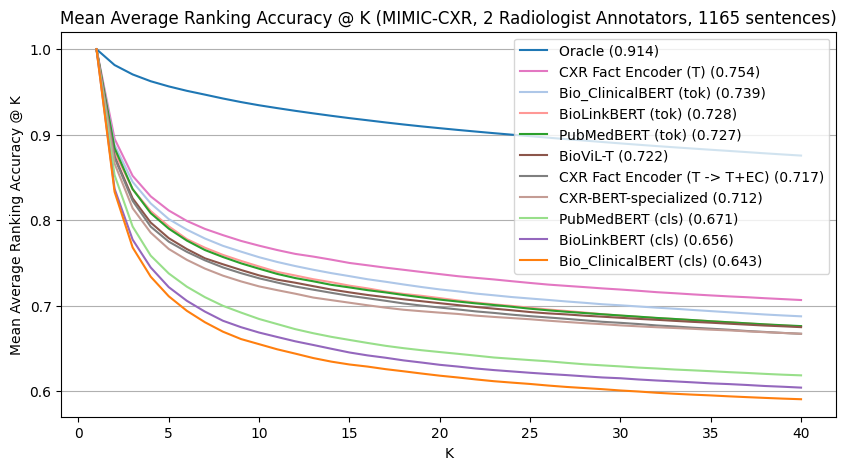

In [3]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metric_lists

metric_paths = [
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200741_mimiccxr_rad_annotations_oracle/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200637_mimiccxr_rad_annotations_emilyalsentzer-Bio_ClinicalBERT/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine,avgtok).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200546_mimiccxr_rad_annotations_emilyalsentzer-Bio_ClinicalBERT/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200454_mimiccxr_rad_annotations_microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine,avgtok).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200402_mimiccxr_rad_annotations_microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200307_mimiccxr_rad_annotations_michiyasunaga-BioLinkBERT-large/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine,avgtok).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_200202_mimiccxr_rad_annotations_michiyasunaga-BioLinkBERT-large/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_195950_mimiccxr_rad_annotations_microsoft-BiomedVLP-BioViL-T/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_195627_mimiccxr_rad_annotations_microsoft-BiomedVLP-CXR-BERT-specialized/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
    
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_225344_MIMIC-CXR(triplets+classif)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/mean_average_accuracy_up_to_500(mimiccxr_rad_annotations,cosine).pkl',
]
metric_lists = [load_pickle(x) for x in metric_paths]
method_names = [
    'Oracle',
    'Bio_ClinicalBERT (tok)',
    'Bio_ClinicalBERT (cls)',
    'PubMedBERT (tok)',
    'PubMedBERT (cls)',
    'BioLinkBERT (tok)',
    'BioLinkBERT (cls)',
    'BioViL-T',
    'CXR-BERT-specialized',
    
    'CXR Fact Encoder (T)',
    'CXR Fact Encoder (T -> T+EC)',
]
plot_metric_lists(
    metric_lists=metric_lists,
    method_names=method_names,
    title="Mean Average Ranking Accuracy @ K (MIMIC-CXR, 2 Radiologist Annotators, 1165 sentences)",
    metric_name='Mean Average Ranking Accuracy @ K',
    xlabel="K",
    figsize=(10, 5),
    first_k=40,
)

# IU X-ray RadGraph labeler

#### microsoft/BiomedVLP-CXR-BERT-specialized

In [43]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "microsoft/BiomedVLP-CXR-BERT-specialized" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: microsoft/BiomedVLP-CXR-BERT-specialized
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=116,1396652957813721259).pkl
len(self.cache["hashes"]) = 111895
self.cache["embeddings"].shape = (111895, 128)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 73841.21it/s]
Embeddings shape: (8617, 128)
Normalizing embeddings (for cosine similarity)
100%|███████████████████████████████████████| 86

#### microsoft/BiomedVLP-BioViL-T

In [47]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "microsoft/BiomedVLP-BioViL-T" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: microsoft/BiomedVLP-BioViL-T
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=104,2678825193822464594).pkl
len(self.cache["hashes"]) = 4444347
self.cache["embeddings"].shape = (4444347, 128)
100%|█████████████████████████████████████| 8617/8617 [00:03<00:00, 2391.25it/s]
Computing embeddings for 7457 new texts
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure n

#### michiyasunaga/BioLinkBERT-large (cls)

In [59]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "michiyasunaga/BioLinkBERT-large" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: michiyasunaga/BioLinkBERT-large
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=107,40983794350539675).pkl
len(self.cache["hashes"]) = 103629
self.cache["embeddings"].shape = (103629, 1024)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 38260.50it/s]
Computing embeddings for 8266 new texts
100%|███████████████████████████████████████████| 83/83 [00:19<00:00,  4.31it/s]
Saving updated

#### michiyasunaga/BioLinkBERT-large (tok)

In [48]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "michiyasunaga/BioLinkBERT-large" \
--batch_size 100 \
--top_k 500 \
--average_token_embeddings

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: michiyasunaga/BioLinkBERT-large
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: True
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=132,1253761809285128054).pkl
len(self.cache["hashes"]) = 103629
self.cache["embeddings"].shape = (103629, 1024)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 38418.74it/s]
Computing embeddings for 8266 new texts
100%|███████████████████████████████████████████| 83/83 [00:19<00:00,  4.29it/s]
Saving update

#### microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext (cls)

In [49]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=137,1948119357925567498).pkl
len(self.cache["hashes"]) = 103629
self.cache["embeddings"].shape = (103629, 768)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 45304.64it/s]
Computing embeddings for 8266 new texts
Some weights of the model checkpoint at microsoft/BiomedNLP-PubM

#### microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext (tok)

In [50]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" \
--batch_size 100 \
--top_k 500 \
--average_token_embeddings

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: True
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=162,1758876944325999998).pkl
len(self.cache["hashes"]) = 103629
self.cache["embeddings"].shape = (103629, 768)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 43230.27it/s]
Computing embeddings for 8266 new texts
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMe

#### emilyalsentzer/Bio_ClinicalBERT (cls)

In [51]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "emilyalsentzer/Bio_ClinicalBERT" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: emilyalsentzer/Bio_ClinicalBERT
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=107,1542209846559636901).pkl
len(self.cache["hashes"]) = 103629
self.cache["embeddings"].shape = (103629, 768)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 45189.70it/s]
Computing embeddings for 8266 new texts
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when ini

#### emilyalsentzer/Bio_ClinicalBERT (tok)

In [52]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "emilyalsentzer/Bio_ClinicalBERT" \
--batch_size 100 \
--top_k 500 \
--average_token_embeddings

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: emilyalsentzer/Bio_ClinicalBERT
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: True
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=132,412155249657523952).pkl
len(self.cache["hashes"]) = 103629
self.cache["embeddings"].shape = (103629, 768)
100%|████████████████████████████████████| 8617/8617 [00:00<00:00, 45231.21it/s]
Computing embeddings for 8266 new texts
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initi

#### Oracle

In [53]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "oracle" \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: oracle
   device: GPU
   batch_size: 32
   num_workers: 4
   model_checkpoint_folder_path: None
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
100%|███████████████████████████████████████| 8617/8617 [08:03<00:00, 17.81it/s]
Saving metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212435_iuxray_radgraph_oracle/mean_average_jaccard_up_to_500(iuxray_radgraph).pkl


#### CXR Fact Encoder (T)

In [66]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "microsoft/BiomedVLP-CXR-BERT-specialized" \
--model_checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)" \
--batch_size 100 \
--top_k 500

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: microsoft/BiomedVLP-CXR-BERT-specialized
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
checkpoint_names = ['checkpoint_40_ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9355.pt']
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=359,388447562913600091).pkl
len(self.cache["hashes"]) =

#### CXR Fact Encoder (T -> T+EC)

In [4]:
!python ../eval_fact_embedding_on_ranking.py \
--evaluation_mode "iuxray_radgraph_labeler" \
--method "microsoft/BiomedVLP-CXR-BERT-specialized" \
--model_checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_225344_MIMIC-CXR(triplets+classif)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/" \
--batch_size 100 \
--top_k 500 \
--

script's arguments:
   evaluation_mode: iuxray_radgraph_labeler
   method: microsoft/BiomedVLP-CXR-BERT-specialized
   device: GPU
   batch_size: 100
   num_workers: 4
   model_checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20230927_225344_MIMIC-CXR(triplets+classif)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/
   top_k: 500
   save_embeddings: False
   distance_metric: cosine
   average_token_embeddings: False
Loading iuxray sentences and radgraph labels from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/iuxray_sentences_and_radgraph_labels.pkl
len(sentences): 8617
len(labels): 8617
checkpoint_names = ['checkpoint_20_encc+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9437.pt']
  0%|                                                  | 0/8617 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=367,2500996363939160178).pkl
len(self.cache["h

In [54]:
reload(medvqa.utils.files)

<module 'medvqa.utils.files' from '/home/pamessina/medvqa/medvqa/utils/files.py'>

In [55]:
from medvqa.utils.files import list_filepaths_with_prefix_and_timestamps

In [67]:
output = list_filepaths_with_prefix_and_timestamps(
    path_prefix='/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927',
    must_contain='iuxray_radgraph',
)

In [68]:
filepaths = [x for x, _ in output]

In [69]:
filepaths

['/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_213652_iuxray_radgraph_michiyasunaga-BioLinkBERT-large/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212435_iuxray_radgraph_oracle/mean_average_jaccard_up_to_500(iuxray_radgraph).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212330_iuxray_radgraph_emilyalsentzer-Bio_ClinicalBERT/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine,avgtok).pkl',
 '/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212205_iuxray_radgraph_emilyalsentzer-Bio_ClinicalBERT/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
 '/m

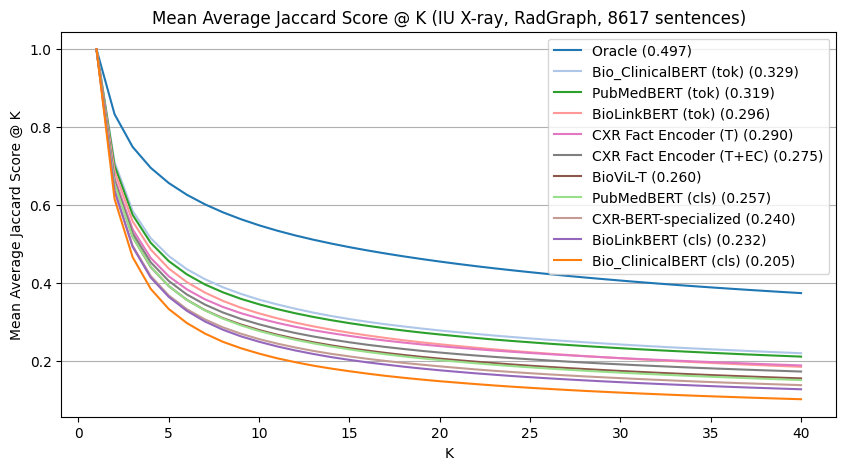

In [5]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metric_lists

metric_paths = [
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212435_iuxray_radgraph_oracle/mean_average_jaccard_up_to_500(iuxray_radgraph).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212330_iuxray_radgraph_emilyalsentzer-Bio_ClinicalBERT/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine,avgtok).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212205_iuxray_radgraph_emilyalsentzer-Bio_ClinicalBERT/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_212040_iuxray_radgraph_microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine,avgtok).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_211921_iuxray_radgraph_microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_211801_iuxray_radgraph_michiyasunaga-BioLinkBERT-large/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine,avgtok).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_213652_iuxray_radgraph_michiyasunaga-BioLinkBERT-large/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_211026_iuxray_radgraph_microsoft-BiomedVLP-BioViL-T/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_205925_iuxray_radgraph_microsoft-BiomedVLP-CXR-BERT-specialized/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
    
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_194923_MIMIC-CXR(triplets-only)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
'/mnt/data/pamessina/workspaces/medvqa-workspace/results/fact_embedding/20230927_225344_MIMIC-CXR(triplets+classif)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/mean_average_jaccard_up_to_500(iuxray_radgraph,cosine).pkl',
]
metric_lists = [load_pickle(x) for x in metric_paths]
method_names = [
    'Oracle',
    'Bio_ClinicalBERT (tok)',
    'Bio_ClinicalBERT (cls)',
    'PubMedBERT (tok)',
    'PubMedBERT (cls)',
    'BioLinkBERT (tok)',
    'BioLinkBERT (cls)',
    'BioViL-T',
    'CXR-BERT-specialized',
    
    'CXR Fact Encoder (T)',
    'CXR Fact Encoder (T+EC)',
]
plot_metric_lists(
    metric_lists=metric_lists,
    method_names=method_names,
    title="Mean Average Jaccard Score @ K (IU X-ray, RadGraph, 8617 sentences)",
    metric_name='Mean Average Jaccard Score @ K',
    xlabel="K",
    figsize=(10, 5),
    first_k=40,
)